Project: 멋진 챗봇 만들기

# 목차

* 평가문항
* 번역 데이터 준비
* 데이터 정제
* 데이터 토큰화
* 데이터 증강
* 데이터 벡터화
* 훈련하기
* 성능 측정하기
* 회고



# 번역 데이터 준비

## 라이브러리와 데이터 준비하기

In [ ]:
!pip install sentencepiece

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
data_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData.csv' # 파일명 주의

In [ ]:
 data = pd.read_csv(data_path)
 
 data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
questions = data['Q']
answers = data['A']

In [ ]:
questions.head()

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

In [ ]:
answers.head()

0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object

# 데이터 정제

In [ ]:
def preprocess_sentence(sentence):
    
    # 모든 입력은 소문자로 변환
    sentence = sentence.lower()
    
    # 영어, 한글, 숫자, 일부 문장부호만를 제외한 나머지 제거
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ0-9.,?!]+", " ", sentence)

    return sentence

In [ ]:
for i in range(len(questions)):
    questions[i] = preprocess_sentence(questions[i])
    
questions.head()

/tmp/ipykernel_715/3758651064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions[i] = preprocess_sentence(questions[i])


0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            ppl 심하네
Name: Q, dtype: object

In [ ]:
for i in range(len(answers)):
    answers[i] = preprocess_sentence(answers[i])
    
answers.head()

/tmp/ipykernel_715/1336527304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers[i] = preprocess_sentence(answers[i])


0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object

# 데이터 토큰화

In [ ]:
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab()

In [ ]:
def build_corpus(que,ans):
    
    X = []
    Y = []
    XX = []
    YY = []
    que_corpus = []
    ans_corpus = []
    
    for i in range(len(que)):
        que[i] = mecab.morphs(que[i])
        ans[i] = mecab.morphs(ans[i])
        
        # 문장의 길이가 40 이하인 데이터만 사용
        if len(que[i])<=40 and len(ans[i])<=40:
            X.append(que[i])
            Y.append(ans[i])
            
    for j in range(len(X)):
        if X[j] not in XX:
            XX.append(X[j])
            YY.append(Y[j])
            
    for k in range(len(YY)):
        if YY[k] not in ans_corpus:
            que_corpus.append(XX[k])
            ans_corpus.append(YY[k])
            
    return que_corpus, ans_corpus

In [ ]:
que_corpus, ans_corpus = build_corpus(questions, answers)

/tmp/ipykernel_715/2326992912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  que[i] = mecab.morphs(que[i])
/tmp/ipykernel_715/2326992912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = mecab.morphs(ans[i])


In [ ]:
que_corpus[:10]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '다']]

In [ ]:
ans_corpus[:10]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.'],
 ['자랑', '하', '는', '자리', '니까요', '.'],
 ['그', '사람', '도', '그럴', '거', '예요', '.'],
 ['혼자', '를', '즐기', '세요', '.']]

In [ ]:
print(len(que_corpus), len(ans_corpus))

7674 7674


# 데이터 증강

In [ ]:
wv_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ko.bin'

In [ ]:
!pip install --upgrade gensim==3.8.3

# 아래 모델을 로드하기 위해서는 젠심을 다운그레이드 해야한다.

In [ ]:
from gensim.models import Word2Vec

In [ ]:
wv = Word2Vec.load(wv_path)

In [ ]:
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec):
    res = ""

    try:
        _from = random.choice(sentence)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in sentence:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [ ]:
new_que = []

for old_src in tqdm(que_corpus):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None: 
        new_src = mecab.morphs(new_src)
        new_que.append(new_src)

    if new_src is None:
        new_que.append(old_src)
        
print(new_que[:10])

  0%|          | 0/7674 [00:00<?, ?it/s]

/tmp/ipykernel_715/1235578097.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


[['12', '시', '땡', '!'], ['1', '중퇴', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '놀', '드', '고', '싶', '다'], ['ppl', '심하', '카나'], ['sd', '카드', '망가졌', '어'], ['sns', '맞', '팔', '왜', '안', '하', '지', '.', '..'], ['sns', '시간', '낭비', '인', '거', '아서', '는데', '매일', '하', '는', '중'], ['sns', '살펴보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'], ['이따금', '궁금', '해'], ['가끔', '은', '혼자', '인', '게', '괜찮', '다']]


In [ ]:
new_ans = []

for old_src in tqdm(ans_corpus):
    new_src = lexical_sub(old_src, wv)
    if new_src is not None:
        new_src = mecab.morphs(new_src)
        new_ans.append(new_src)
    
    if new_src is None:
        new_ans.append(old_src)
        
print(new_ans[:10])

  0%|          | 0/7674 [00:00<?, ?it/s]

/tmp/ipykernel_715/1235578097.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


[['하루', '가', '또', '가', '군요', '.'], ['위', '로', '해', '의', '드립니다', '.'], ['여행', '은', '언제나', '괜찮', '죠', '.'], ['눈살', '이', '찌푸려', '꼼짝', '죠', '.'], ['다시', '새로이', '사', '는', '게', '마음', '편해요', '.'], ['잘', '모르', '고', '있', '을', '수', '때문', '있', '어요', '.'], ['시간', '을', '정하', '고', '해', '보', 'ㅂ시오', '.'], ['자랑', '하', '는', '자리', 'ㄴ', '데요', '.'], ['그녀', '사람', '도', '그럴', '거', '예요', '.'], ['거기', '를', '즐기', '세요', '.']]


In [ ]:
print(len(new_que), len(new_ans))

7674 7674


In [ ]:
aug_que = []
aug_que = que_corpus + new_que + que_corpus
len(aug_que)

23022

In [ ]:
aug_ans = []
aug_ans = ans_corpus + ans_corpus + new_ans
len(aug_ans)

23022

# 데이터 벡터화

In [ ]:
# 시작 및 종료 토큰 추가
for i in range(len(aug_que)):
    aug_que[i] = ["<start>"] + aug_que[i] + ["<end>"]
    aug_ans[i] = ["<start>"] + aug_ans[i] + ["<end>"]

In [ ]:
print(aug_que[:5])
print(aug_ans[:5])

[['<start>', '12', '시', '땡', '!', '<end>'], ['<start>', '1', '지망', '학교', '떨어졌', '어', '<end>'], ['<start>', '3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다', '<end>'], ['<start>', 'ppl', '심하', '네', '<end>'], ['<start>', 'sd', '카드', '망가졌', '어', '<end>']]
[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'], ['<start>', '위로', '해', '드립니다', '.', '<end>'], ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'], ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'], ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>']]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
VOCAB_SIZE = 8000
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = 'OOV')
tokenizer.fit_on_texts(aug_que + aug_ans)

In [ ]:
print(tokenizer.word_index)

{'OOV': 1, '<start>': 2, '<end>': 3, '.': 4, '이': 5, '는': 6, '하': 7, '을': 8, '가': 9, '좋': 10, '고': 11, '세요': 12, '어': 13, '거': 14, '있': 15, '해': 16, '은': 17, '지': 18, '보': 19, '나': 20, '?': 21, '아': 22, '도': 23, '게': 24, '에': 25, '는데': 26, '겠': 27, '사람': 28, '예요': 29, '사랑': 30, '를': 31, '어요': 32, '의': 33, '같': 34, '한': 35, '죠': 36, '없': 37, '것': 38, '다': 39, '수': 40, '면': 41, '네': 42, '싶': 43, '네요': 44, '안': 45, '친구': 46, '봐요': 47, '생각': 48, '않': 49, '아요': 50, '말': 51, '마음': 52, '할': 53, '주': 54, '되': 55, '기': 56, '너무': 57, '했': 58, '잘': 59, '었': 60, '내': 61, '이별': 62, '남자': 63, '만': 64, '더': 65, '연락': 66, '일': 67, '여자': 68, '들': 69, '힘들': 70, '남': 71, '해요': 72, '썸': 73, '시간': 74, '많이': 75, '짝': 76, '으로': 77, '길': 78, '요': 79, '한테': 80, '건': 81, '으면': 82, '때': 83, '았': 84, '인': 85, '에서': 86, '적': 87, '에요': 88, '로': 89, '괜찮': 90, '좀': 91, '야': 92, '그': 93, '알': 94, '만나': 95, '받': 96, '많': 97, '연애': 98, '을까': 99, '에게': 100, '저': 101, '애': 102, '못': 103, '습니다': 104, '던': 105, '뭐': 106, '먹

In [ ]:
enc_train = tokenizer.texts_to_sequences(aug_que)
dec_train = tokenizer.texts_to_sequences(aug_ans)

In [ ]:
# 앞에서 설정한 문장 길이 40에 시작, 종료 토큰 합쳐서 42의 크기로 패딩한다.

from tensorflow.keras.preprocessing.sequence import pad_sequences

enc_train = pad_sequences(enc_train, padding='post', maxlen=42)
dec_train = pad_sequences(dec_train, padding='post', maxlen=42)

# 훈련하기

이전 노드에서 미리 만들어둔 함수를 사용한다.

In [ ]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [ ]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [ ]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [ ]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [ ]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [ ]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer 전체 모델 조립

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=1,
    d_model=368,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

In [ ]:
d_model=368

In [ ]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [ ]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [ ]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

In [ ]:
# 훈련시키기
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

In [ ]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

In [ ]:
# bleu 계산

def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > 42): return None
    if (len(tgt_tokens) > 42): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

In [ ]:
MAX_LEN = 42

In [ ]:
def v2w(dict):
    vec_to_word = {}
    for k,v in dict.items():
        vec_to_word[v]=k
    
    return vec_to_word    

In [ ]:
vec_to_word = v2w(tokenizer.word_index)

In [ ]:
def gen_sen(tokens, model=transformer, src_tokenizer=tokenizer, tgt_tokenizer=tokenizer):
    tokens = preprocess_sentence(tokens)
    tokens = mecab.morphs(tokens)
    tokens = tokenizer.texts_to_sequences(tokens)
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([2], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if 3 == predicted_id:
             
            return ids

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    #result = tgt_tokenizer.decode_ids(ids)
    
    return ids

# 성능 측정하기

In [ ]:
for i in gen_sen('지루하다, 놀러가고 싶어.'):
    print(vec_to_word[i], end=' ')

다른 답답 답답 해 다른 생각 해 보 세요 . 

In [ ]:
for i in gen_sen('오늘 일찍 일어났더니 피곤하다.'):
    print(vec_to_word[i], end=' ')

오늘 은 버티 성장 을 해 의 보 세요 . 

In [ ]:
for i in gen_sen('간만에 여자친구랑 데이트 하기로 했어.'):
    print(vec_to_word[i], end=' ')

떨리 죠 . 

In [ ]:
for i in gen_sen('집에 있는다는 소리야.'):
    print(vec_to_word[i], end=' ')

우연 로서 풀 내 집 에 도 갖 는 좋 은데요 . 

In [ ]:
    n_layers=1,
    d_model=368,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    EPOCHS = 10
    warmup_steps=1000
    BATCH_SIZE = 64

* epoch=5 일 때의 결과 일부

![[GDProject_6]Chatbot - Jupyter Notebook.png](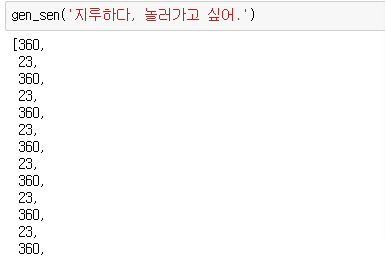)

# 회고

이번 노드에서는 번역기와 비슷한 방식을 가지고 챗봇을 만들었다. 번역기는 번역 대상이 되는 언어의 문장과 타겟이 되는 문장의 쌍으로 이루어져 있어서 이것들을 연결해 모델을 학습하고 결과를 얻는다. 마찬가지로 qna 역시 문장의 쌍으로 이루어져 있으므로 같은 방법을 사용할 수 있는 것이다. 

그러나 몇 가지 문제점이 있었는데 얼마나 학습해야 좋을지 알기 어렵다는 점이었다. 학습이 부족하면 위의 사진처럼 일부 단어만을 반복하는 문제가 심각하게 발생했으며 너무 많이 학습하면 데이터의 부족으로 오버피팅이 발생할 수 있었기 때문이다. 그런데 이런 오류를 발견하기 위해서는 사람이 직접 확인해야하므로 꽤나 쉽지 않은 일이었다.

우리가 처음 가진 데이터는 각 문장쌍의 갯수가 7000개 정도였다. 이는 매우 적은 양이기 때문에 데이터 증강을 하는 과정을 가졌다. 문장 내에 있는 한 단어를 무작위로 고른 후 그것과 비슷한 다른 단어로 대체한 것이다. word2vec으로 유사한 단어를 찾을 수 있었으며 이렇게 각 질문 데이터와 대답 데이터에 같은 방식으로 데이터의 양을 2배로 늘릴 수 있었으며 실제로 우리가 사용할 데이터는 이것들의 문장 쌍이므로 결합하는 방식을 다르게 함으로써 실제 데이터를 3배로 늘려 사용했다.